
# TDA Improvements: Tuned Stable Rank + Cubical Intensity Betti Curves

You reported ~68% for homological SVM and ~78% for the non‑TDA baseline.
This notebook gives two stronger TDA tracks to try:

**A) VR Stable‑Rank (tuned)**  
- pooled global `t_max` and **log‑spaced** grid  
- **persistence thresholding** to drop short bars (noise)  
- optional **PCA** (e.g., 64 dims) so you can raise subsample size **m** safely  
- **H0+H1** stable‑rank features concatenated  
- **CV SVM** with a small grid

**B) Cubical Intensity Betti Curves (spectrogram image, GUDHI)**  
- superlevel filtration on the (downsampled) spectrogram image  
- **H0+H1 Betti curves** over intensity thresholds  
- CV SVM

Evaluate both; one of these typically narrows (or beats) your 78% baseline.


In [6]:

# If an import fails, run the install lines below and re-run.
import os, json, math, warnings
import numpy as np
from pathlib import Path
from tqdm import tqdm
from joblib import Parallel, delayed

# ML
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report

# TDA
from ripser import ripser                         # pip/conda
import gudhi                                     # conda-forge recommended
from gudhi import CubicalComplex

warnings.filterwarnings('ignore')
print("Imports OK")

Imports OK


In [18]:

# %pip install -q ripser gudhi scikit-learn joblib tqdm
# Or:
# !conda install -y -c conda-forge ripser gudhi scikit-learn tqdm joblib


## Common setup

In [2]:

BASE_DIR     = '.'
META_PATH    = os.path.join(BASE_DIR, 'stft_np', 'meta.json')
np.set_printoptions(precision=4, suppress=True)

# How many clips per class to use for experiments
N_PER_CLASS  = 800         # bump up if compute allows
TEST_SIZE    = 0.2
RANDOM_STATE = 42

# Load memmaps
with open(META_PATH, 'r') as f:
    meta = json.load(f)

dtype_str = meta.get('dtype', 'float16')
if isinstance(dtype_str, str) and dtype_str.startswith("<class 'numpy."):
    dtype_str = dtype_str.split('.')[-1].split("'")[0]

A_mm = np.memmap(os.path.join(BASE_DIR, 'stft_np', meta['A_memmap']), dtype=dtype_str, mode='r', shape=tuple(meta['A_shape']))
B_mm = np.memmap(os.path.join(BASE_DIR, 'stft_np', meta['B_memmap']), dtype=dtype_str, mode='r', shape=tuple(meta['B_shape']))
print("A:", A_mm.shape, "B:", B_mm.shape)

# Labels
rng = np.random.default_rng(RANDOM_STATE)
nA, nB = A_mm.shape[0], B_mm.shape[0]
nA_use = min(N_PER_CLASS, nA)
nB_use = min(N_PER_CLASS, nB)
idxA = rng.choice(nA, size=nA_use, replace=False)
idxB = rng.choice(nB, size=nB_use, replace=False)
y   = np.concatenate([np.zeros(nA_use, dtype=int), np.ones(nB_use, dtype=int)])

def db_to_unit(x_db):
    y = (x_db + 80.0) / 80.0
    return np.clip(y, 0.0, 1.0).astype(np.float32, copy=False)

def spec_to_pointcloud(db_spec, zscore=True, l2norm=True):
    X = db_to_unit(db_spec)               # (T,F)
    if zscore:
        mu = X.mean(axis=0, keepdims=True)
        sd = X.std(axis=0, keepdims=True) + 1e-6
        X = (X - mu) / sd
    if l2norm:
        nrm = np.linalg.norm(X, axis=1, keepdims=True) + 1e-9
        X = X / nrm
    return X.astype(np.float32, copy=False)


A: (940, 1000, 257) B: (973, 1000, 257)


## Track A — Tuned VR Stable‑Rank (H0 + H1)

In [ ]:

# --- Config for Track A ---
COEFF            = 2          # prime field for ripser
USE_PCA          = True
PCA_DIM          = 64
SUBSAMPLE_M      = 400        # m >= PCA_DIM+1 to avoid warnings
N_SUBS           = 4
T_POINTS         = 128         # curve length
PERSIST_TAU_FRAC = 0.02       # drop bars with (death - birth) < tau_frac * t_max
GRID_LOGSPACE    = True       # log-spaced t-grid tends to help shape

print("Track A configured.")

Track A configured.


In [4]:

def pooled_tmax(mmA, mmB, idxA, idxB, frames=200, clips=12, q=0.95, seed=RANDOM_STATE):
    rng = np.random.default_rng(seed)
    pool = []
    for mm, idxs in [(mmA, idxA), (mmB, idxB)]:
        pick = rng.choice(idxs, size=min(clips, len(idxs)), replace=False)
        for i in pick:
            db = np.array(mm[i], dtype=np.float32)
            pc = spec_to_pointcloud(db)
            J = rng.choice(pc.shape[0], size=min(frames, pc.shape[0]), replace=False)
            pool.append(pc[J])
    X = np.vstack(pool)
    # sample some pairwise distances
    K = min(20000, X.shape[0]*(X.shape[0]-1)//2)
    I = rng.integers(0, X.shape[0], size=(K,2))
    D = np.linalg.norm(X[I[:,0]] - X[I[:,1]], axis=1)
    return float(np.quantile(D, q))

t_max = pooled_tmax(A_mm, B_mm, idxA, idxB)
if GRID_LOGSPACE:
    t_vals = np.geomspace(max(t_max/1e4, 1e-5), t_max, T_POINTS).astype(np.float32)
else:
    t_vals = np.linspace(0.0, t_max, T_POINTS).astype(np.float32)
print("t_max≈", t_max, "grid len:", len(t_vals))

t_max≈ 1.7025048732757568 grid len: 128


In [5]:

def drop_short_bars(H, tau):
    # H: (k,2) birth,death
    if H.size == 0: return H
    pers = H[:,1] - H[:,0]
    keep = pers >= tau
    return H[keep] if keep.any() else np.empty((0,2), dtype=np.float64)

def h_diagram(points, dim, t_max=None, coeff=2):
    R = ripser(points, maxdim=dim, coeff=coeff, thresh=t_max, do_cocycles=False)
    dgms = R['dgms']
    if dim >= len(dgms): return np.empty((0,2), dtype=np.float64)
    H = dgms[dim]
    if H.size:
        finite = np.isfinite(H[:,1])
        if finite.any():
            m = H[finite,1].max()
            H[~finite,1] = m * 1.05
        else:
            H = np.empty((0,2), dtype=np.float64)
    return H

def betti_curve(diag, t_vals):
    if diag.size == 0: return np.zeros_like(t_vals, dtype=np.float32)
    b = diag[:,0][:,None]; d = diag[:,1][:,None]; t = t_vals[None,:]
    return ((b <= t) & (t < d)).sum(axis=0).astype(np.float32)

# Fit PCA once on a small pooled set
PCA_MODEL = None
if USE_PCA:
    rng = np.random.default_rng(RANDOM_STATE)
    pool = []
    for mm, idxs in [(A_mm, idxA), (B_mm, idxB)]:
        pick = rng.choice(idxs, size=min(10, len(idxs)), replace=False)
        for i in pick:
            db = np.array(mm[i], dtype=np.float32)
            pc = spec_to_pointcloud(db)
            J = rng.choice(pc.shape[0], size=min(300, pc.shape[0]), replace=False)
            pool.append(pc[J])
    Xpool = np.vstack(pool)
    PCA_MODEL = PCA(n_components=PCA_DIM, random_state=RANDOM_STATE).fit(Xpool)
    print("Fitted PCA:", PCA_MODEL.n_components_)

Fitted PCA: 64


In [23]:

from joblib import Parallel, delayed

def features_vr(mm, indices, t_vals, coeff=COEFF, m=SUBSAMPLE_M, n_subs=N_SUBS, use_pca=USE_PCA, tau_frac=PERSIST_TAU_FRAC):
    t_cap = float(t_vals[-1])
    tau = tau_frac * t_cap
    def one(idx):
        db = np.array(mm[idx], dtype=np.float32)
        pc = spec_to_pointcloud(db)
        if use_pca and PCA_MODEL is not None:
            pc = PCA_MODEL.transform(pc)   # (1000, PCA_DIM)
        N = pc.shape[0]
        rng = np.random.default_rng(RANDOM_STATE+idx)
        acc0 = np.zeros_like(t_vals, dtype=np.float32)
        acc1 = np.zeros_like(t_vals, dtype=np.float32)
        for _ in range(n_subs):
            I = rng.choice(N, size=min(m, N), replace=False)
            H0 = drop_short_bars(h_diagram(pc[I], 0, t_max=t_cap, coeff=coeff), tau)
            H1 = drop_short_bars(h_diagram(pc[I], 1, t_max=t_cap, coeff=coeff), tau)
            acc0 += betti_curve(H0, t_vals)
            acc1 += betti_curve(H1, t_vals)
        return np.hstack([(acc0/n_subs), (acc1/n_subs)]).astype(np.float32)
    out = Parallel(n_jobs=-1, prefer='processes')(delayed(one)(i) for i in tqdm(indices, desc="VR stable‑rank"))
    return np.vstack(out)

print("Building Track A features...")
XA = features_vr(A_mm, idxA, t_vals)
XB = features_vr(B_mm, idxB, t_vals)
X_A = np.vstack([XA, XB]).astype(np.float32); y_A = y.copy()
print("Track A feature shape:", X_A.shape)

Building Track A features...


VR stable‑rank: 100%|██████████| 800/800 [00:43<00:00, 18.32it/s]


Track A feature shape: (1600, 256)


In [24]:

# Cross-validated SVM for Track A
param_grid = {
    'svc__C': [0.5, 1.0, 2.0, 5.0, 10.0],
    'svc__gamma': ['scale', 1e-2, 5e-3, 1e-3]
}
pipe = make_pipeline(StandardScaler(), SVC(kernel='rbf', probability=False, random_state=RANDOM_STATE))
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

gs = GridSearchCV(pipe, param_grid=param_grid, cv=cv, n_jobs=-1, scoring='accuracy', verbose=0)
sss = StratifiedShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=RANDOM_STATE)
train_idx, test_idx = next(sss.split(X_A, y_A))

gs.fit(X_A[train_idx], y_A[train_idx])
y_pred = gs.predict(X_A[test_idx])

print("Track A — best params:", gs.best_params_)
print("Track A — Test Acc:", accuracy_score(y_A[test_idx], y_pred))
print("Track A — Test F1 (weighted):", f1_score(y_A[test_idx], y_pred, average='weighted'))
print()
print(classification_report(y_A[test_idx], y_pred, target_names=['A','B']))

Track A — best params: {'svc__C': 2.0, 'svc__gamma': 'scale'}
Track A — Test Acc: 0.78125
Track A — Test F1 (weighted): 0.7812158149710893

              precision    recall  f1-score   support

           A       0.79      0.77      0.78       160
           B       0.77      0.79      0.78       160

    accuracy                           0.78       320
   macro avg       0.78      0.78      0.78       320
weighted avg       0.78      0.78      0.78       320



## Track B — Cubical Intensity Betti Curves (GUDHI)

In [25]:

# --- Config for Track B ---
HOM_FIELD  = 2
IMG_H, IMG_W = 128, 128       # downsampled spectrogram resolution
T_POINTS_I = 128 #64               # intensity grid points
SMOOTH_SIG = 0.0              # optional Gaussian smoothing in time/freq before TDA
print("Track B configured.")

Track B configured.


In [26]:

from scipy import ndimage

def spec_image(db_spec, hw=(128,128), smooth_sig=0.0):
    img = db_to_unit(db_spec)                # (T,F) in [0,1]
    if smooth_sig > 0:
        img = ndimage.gaussian_filter(img, sigma=smooth_sig, mode='nearest')
    H, W = hw
    zoom_y = H / img.shape[0]; zoom_x = W / img.shape[1]
    img_ds = ndimage.zoom(img, (zoom_y, zoom_x), order=1)
    return np.clip(img_ds, 0.0, 1.0).astype(np.float32)

def intensity_grid(img, T=64):
    # superlevel via sublevel: run on (1 - img)
    lo, hi = 0.0, 1.0
    return np.linspace(lo, hi, T, dtype=np.float32)

def betti_curve_cubical(img, levels, field=2, dim=1):
    # superlevel on img via sublevel on (1 - img)
    topo = (1.0 - img).astype(np.float64, copy=False)
    cc = CubicalComplex(dimensions=topo.shape,
                        top_dimensional_cells=topo.ravel(order='C'))

    # Older GUDHI versions don't support persistence_dim_max; compute all, then slice by dim
    cc.persistence(homology_coeff_field=field)

    diag = cc.persistence_intervals_in_dimension(dim)
    if diag.size == 0:
        return np.zeros_like(levels, dtype=np.float32)

    # Replace infinite deaths with a cap slightly beyond the top level
    inf = ~np.isfinite(diag[:, 1])
    if inf.any():
        diag[inf, 1] = float(levels[-1]) + 1e-6

    b = diag[:, 0][:, None]
    d = diag[:, 1][:, None]
    t = levels[None, :]
    alive = (b <= t) & (t < d)
    return alive.sum(axis=0).astype(np.float32)

def features_cubical(mm, indices, hw=(128,128), T=64, field=2, smooth=0.0):
    levels = intensity_grid(np.zeros(hw, dtype=np.float32), T)
    def one(idx):
        db = np.array(mm[idx], dtype=np.float32)
        img = spec_image(db, hw=hw, smooth_sig=smooth)
        c0 = betti_curve_cubical(img, levels, field=field, dim=0)
        c1 = betti_curve_cubical(img, levels, field=field, dim=1)
        return np.hstack([c0, c1]).astype(np.float32)
    out = Parallel(n_jobs=-1, prefer='processes')(delayed(one)(i) for i in tqdm(indices, desc="Cubical Betti curves"))
    return np.vstack(out)

print("Building Track B features...")
XA = features_cubical(A_mm, idxA, hw=(IMG_H, IMG_W), T=T_POINTS_I, field=HOM_FIELD, smooth=SMOOTH_SIG)
XB = features_cubical(B_mm, idxB, hw=(IMG_H, IMG_W), T=T_POINTS_I, field=HOM_FIELD, smooth=SMOOTH_SIG)
X_B = np.vstack([XA, XB]).astype(np.float32); y_B = y.copy()
print("Track B feature shape:", X_B.shape)

Building Track B features...


Cubical Betti curves: 100%|██████████| 800/800 [00:11<00:00, 70.50it/s]


Track B feature shape: (1600, 256)


In [27]:

# Cross-validated SVM for Track B
param_grid = {'svc__C':[0.5,1,2,5,10], 'svc__gamma':['scale',1e-3,5e-4,1e-4]}
pipe = make_pipeline(StandardScaler(), SVC(kernel='rbf', random_state=RANDOM_STATE))
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
gs = GridSearchCV(pipe, param_grid=param_grid, cv=cv, n_jobs=-1, scoring='accuracy')

sss = StratifiedShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=RANDOM_STATE)
train_idx, test_idx = next(sss.split(X_B, y_B))

gs.fit(X_B[train_idx], y_B[train_idx])
y_pred = gs.predict(X_B[test_idx])

print("Track B — best params:", gs.best_params_)
print("Track B — Test Acc:", accuracy_score(y_B[test_idx], y_pred))
print("Track B — Test F1 (weighted):", f1_score(y_B[test_idx], y_pred, average='weighted'))
print()
print(classification_report(y_B[test_idx], y_pred, target_names=['A','B']))

Track B — best params: {'svc__C': 10, 'svc__gamma': 0.001}
Track B — Test Acc: 0.809375
Track B — Test F1 (weighted): 0.8093731384095548

              precision    recall  f1-score   support

           A       0.81      0.81      0.81       160
           B       0.81      0.81      0.81       160

    accuracy                           0.81       320
   macro avg       0.81      0.81      0.81       320
weighted avg       0.81      0.81      0.81       320



In [28]:
import numpy as np
import matplotlib.pyplot as plt

# X_A: (n, 2*T), y_A: (n,), t_vals: (T,)
T = len(t_vals)
H0 = X_A[:, :T]
H1 = X_A[:, T:]

def plot_family(curves, labels, t, title, max_per_class=80, alpha=0.15, lw=1.0, out_png=None, seed=0):
    rng = np.random.default_rng(seed)
    classes = np.unique(labels)
    plt.figure(figsize=(7,7))
    handles = []
    for c in classes:
        idx = np.where(labels == c)[0]
        if idx.size > max_per_class:
            idx = rng.choice(idx, size=max_per_class, replace=False)
        # draw one line to set color
        line, = plt.plot(t, curves[idx[0]], linewidth=lw, alpha=0.9, label=f"class {int(c)}")
        handles.append(line)
        col = line.get_color()
        for i in idx[1:]:
            plt.plot(t, curves[i], linewidth=lw, alpha=alpha, color=col)
    plt.xlabel("t (scale)")
    plt.ylabel("stable rank (Betti count)")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend(handles=handles, loc="upper right")
    plt.tight_layout()
    if out_png:
        plt.savefig(out_png, dpi=150)
    plt.show()

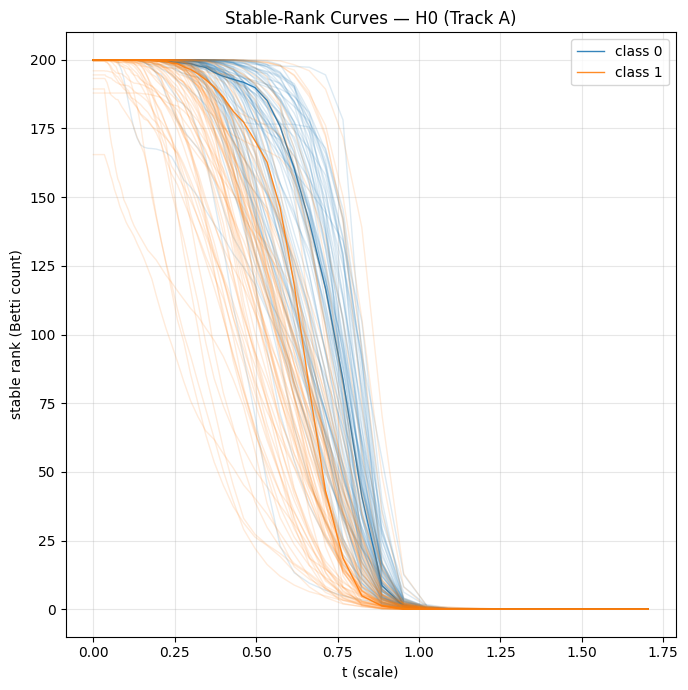

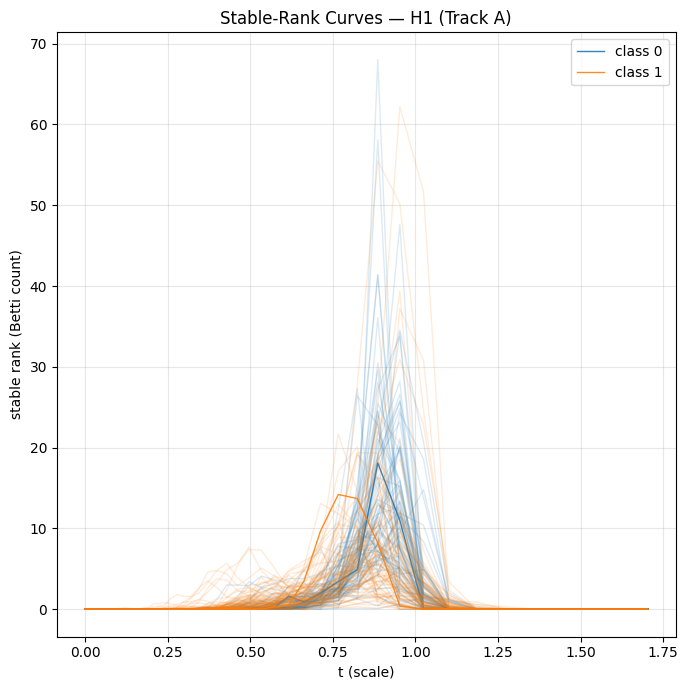

In [29]:
plot_family(H0, y_A, t_vals, title="Stable-Rank Curves — H0 (Track A)", out_png="H0_stable_ranks.png")
plot_family(H1, y_A, t_vals, title="Stable-Rank Curves — H1 (Track A)", out_png="H1_stable_ranks.png")

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from ripser import ripser

def _handle_infinite(diag, cap):
    if diag.size == 0: return diag
    inf = ~np.isfinite(diag[:, 1])
    if inf.any():
        diag = diag.copy()
        diag[inf, 1] = cap + 1e-6
    return diag

def compute_diagrams_for_clip(mm, raw_idx, t_cap, coeff=2):
    # Uses the same preprocessing as Track A
    db = np.array(mm[raw_idx], dtype=np.float32)
    pc = spec_to_pointcloud(db)                        # (1000, D)
    if 'USE_PCA' in globals() and USE_PCA and ('PCA_MODEL' in globals()) and (PCA_MODEL is not None):
        pc = PCA_MODEL.transform(pc)                   # (1000, PCA_DIM)

    R = ripser(pc, maxdim=1, thresh=float(t_cap), coeff=coeff, do_cocycles=False)
    H0 = R['dgms'][0] if len(R['dgms']) > 0 else np.empty((0,2), float)
    H1 = R['dgms'][1] if len(R['dgms']) > 1 else np.empty((0,2), float)

    H0 = _handle_infinite(H0, t_cap)
    H1 = _handle_infinite(H1, t_cap)

    # optional persistence pruning, matching Track A if set
    tau_frac = globals().get('PERSIST_TAU_FRAC', 0.0)
    if tau_frac > 0:
        tau = tau_frac * float(t_cap)
        keep0 = (H0[:,1] - H0[:,0]) >= tau
        keep1 = (H1[:,1] - H1[:,0]) >= tau
        H0 = H0[keep0] if H0.size else H0
        H1 = H1[keep1] if H1.size else H1
    return H0, H1

def plot_persistence_diagram(diag, title=""):
    plt.figure(figsize=(4.5,4.5))
    if diag.size:
        x, y = diag[:,0], diag[:,1]
        lo = min(0.0, float(np.min(x)), float(np.min(y)))
        hi = max(float(np.max(x)), float(np.max(y)))
        plt.scatter(x, y, s=14, alpha=0.8)
        plt.plot([lo, hi], [lo, hi], 'k--', lw=1)
        plt.xlim(lo, hi); plt.ylim(lo, hi)
    plt.xlabel("birth"); plt.ylabel("death"); plt.title(title)
    plt.grid(True, alpha=0.25)
    plt.tight_layout(); plt.show()

def plot_barcode(diag, title="", kmax=40):
    if diag.size == 0:
        plt.figure(); plt.title(title + " (empty)"); plt.show(); return
    per = (diag[:,1] - diag[:,0])
    order = np.argsort(-per)[:kmax]
    d = diag[order]
    y = np.arange(len(d))
    plt.figure(figsize=(6, 0.25*len(d) + 1.8))
    for i, (b, e) in enumerate(d):
        plt.plot([b, e], [i, i], lw=2)
    plt.xlabel("t (scale)"); plt.yticks([])
    plt.title(title + f"  (top {len(d)} by persistence)")
    plt.grid(True, axis='x', alpha=0.2)
    plt.tight_layout(); plt.show()


Class 0 samples:


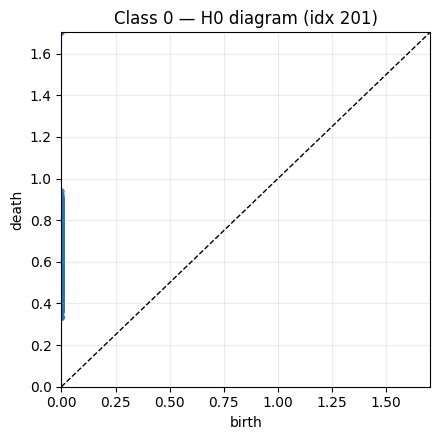

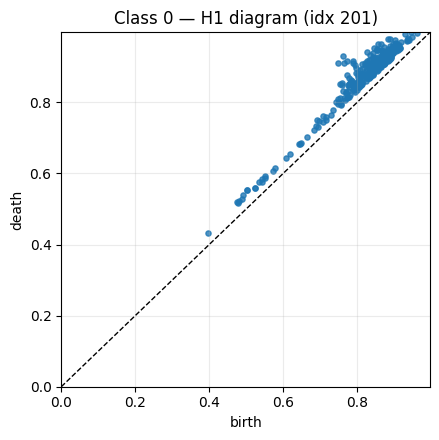

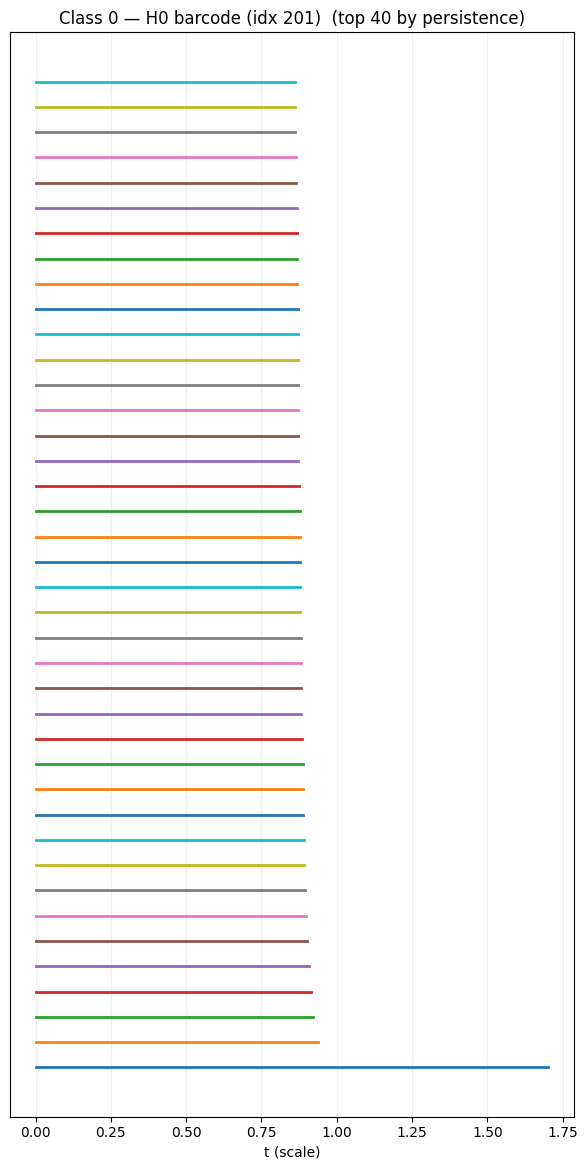

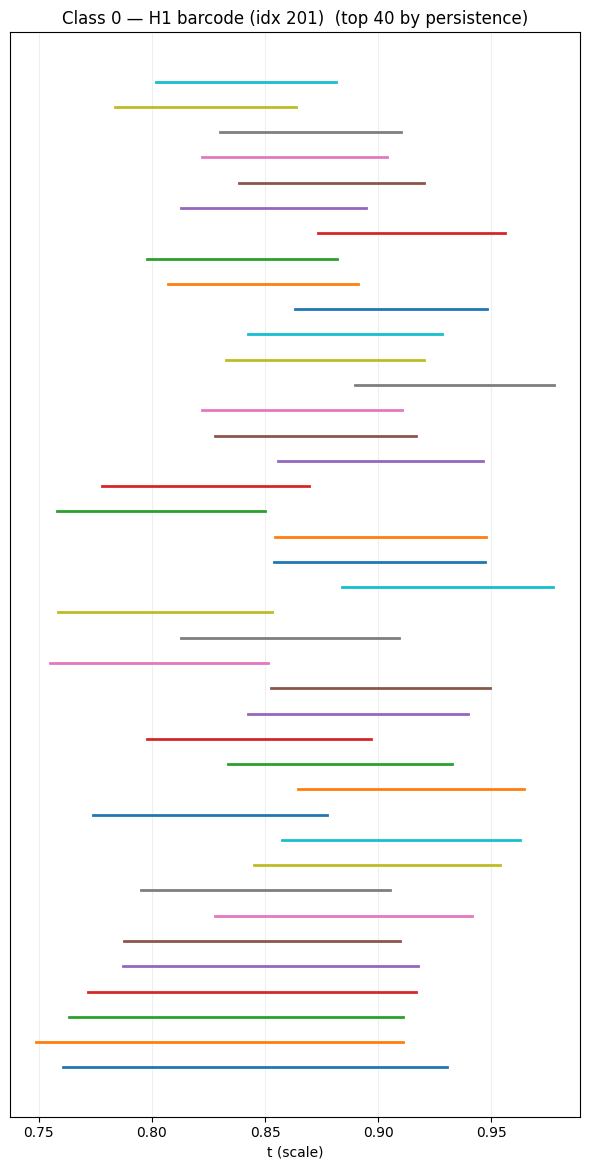

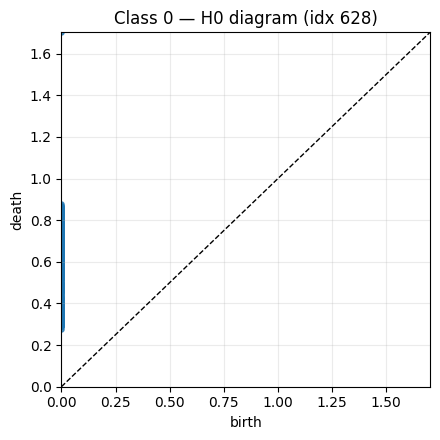

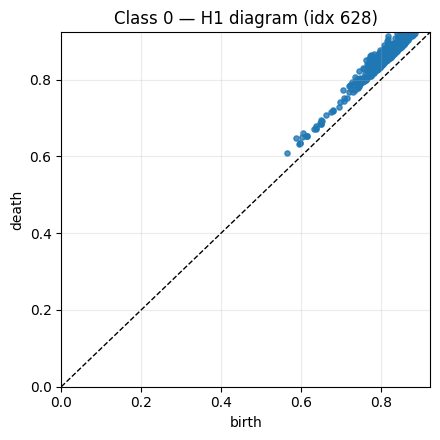

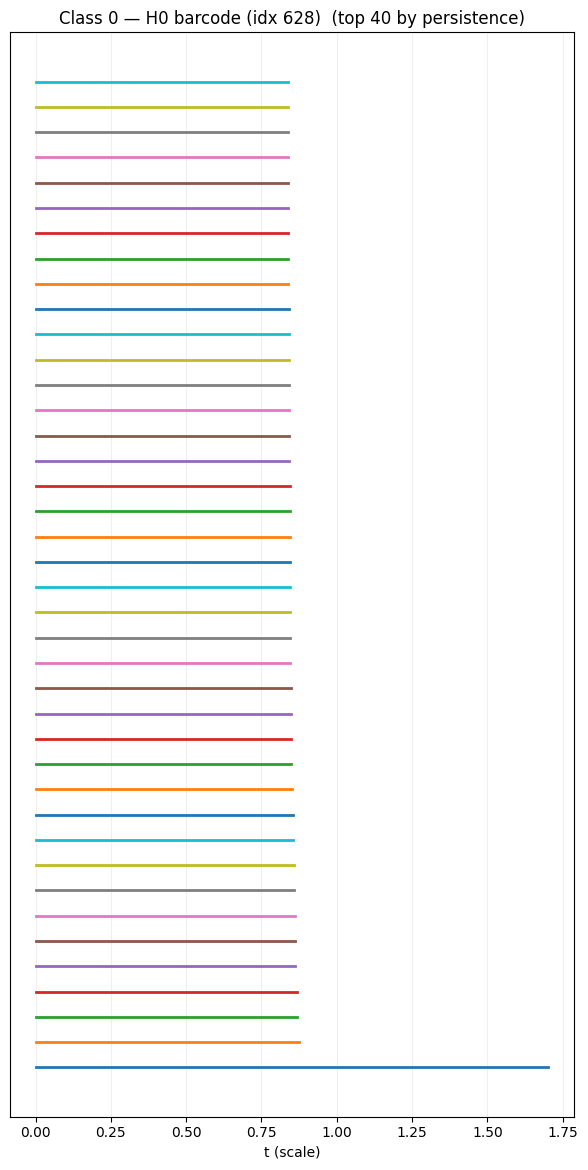

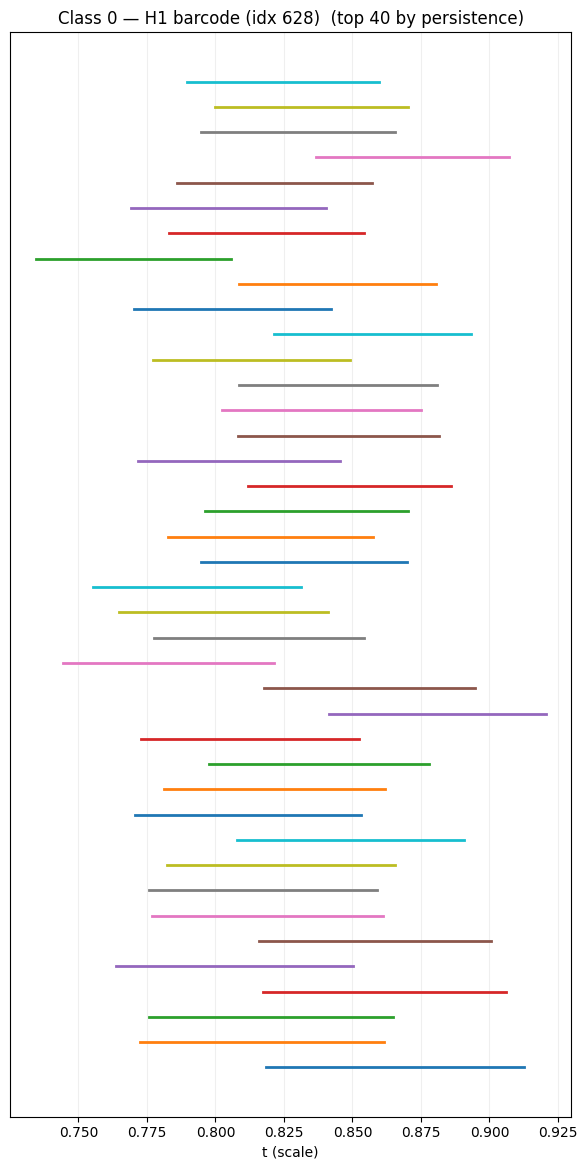

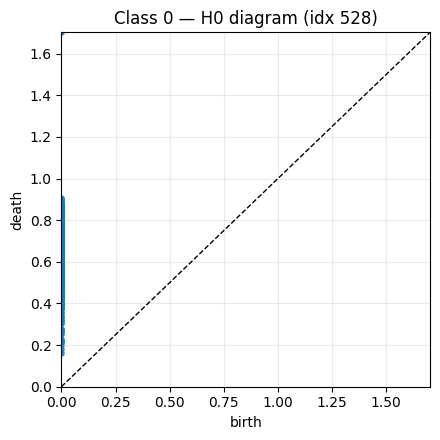

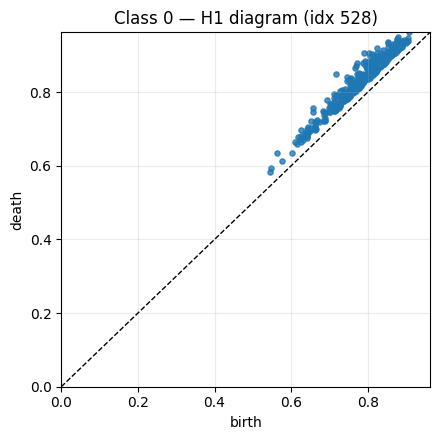

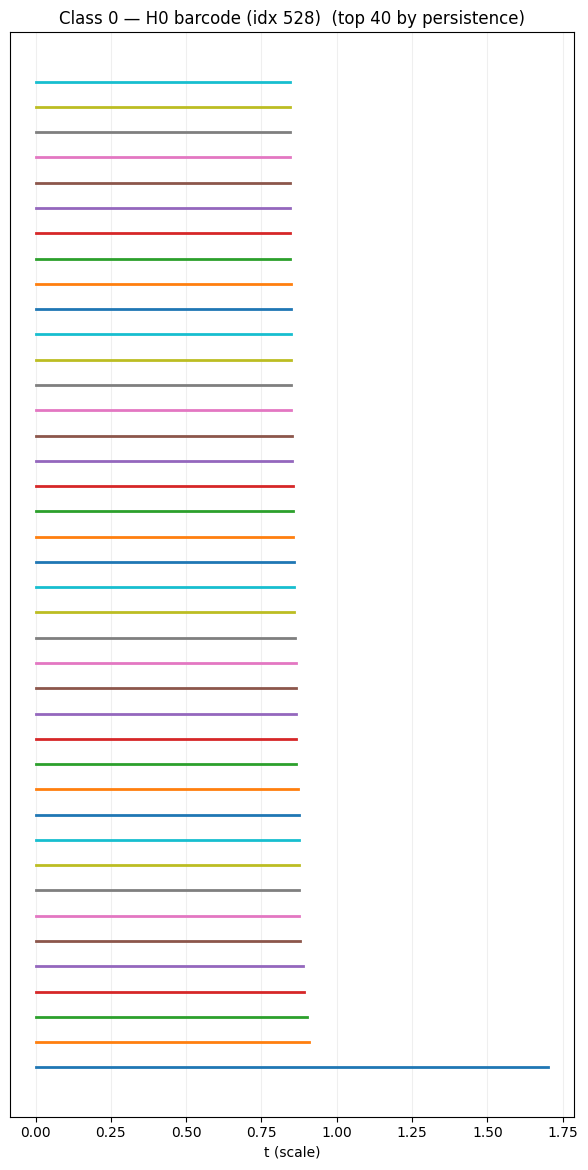

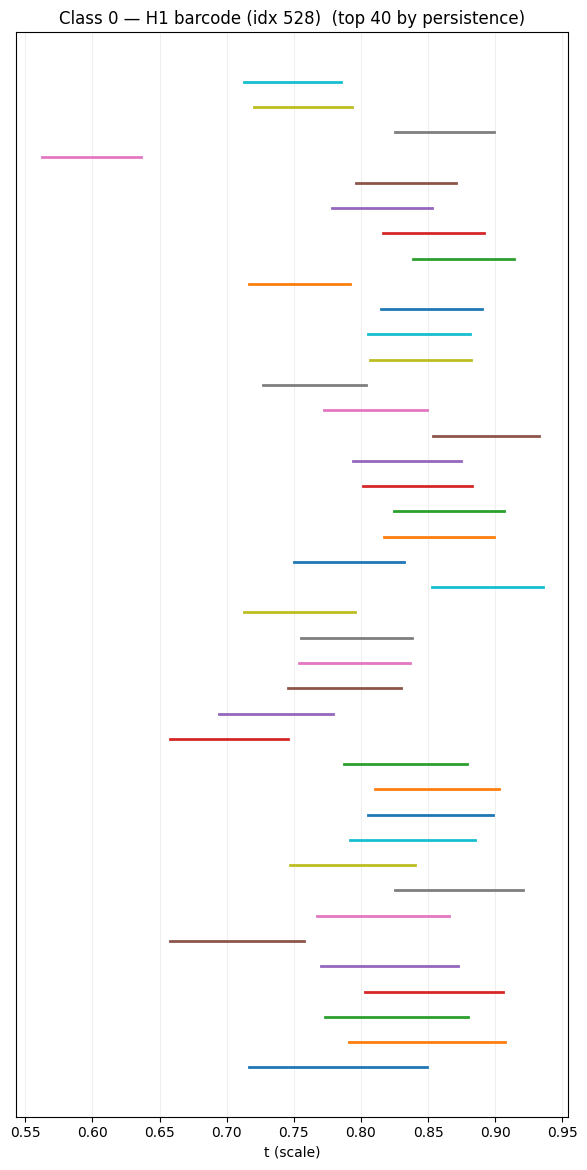

Class 1 samples:


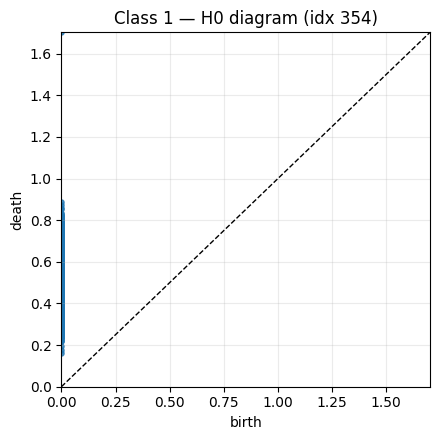

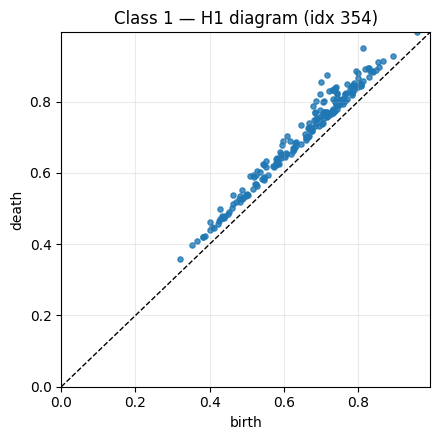

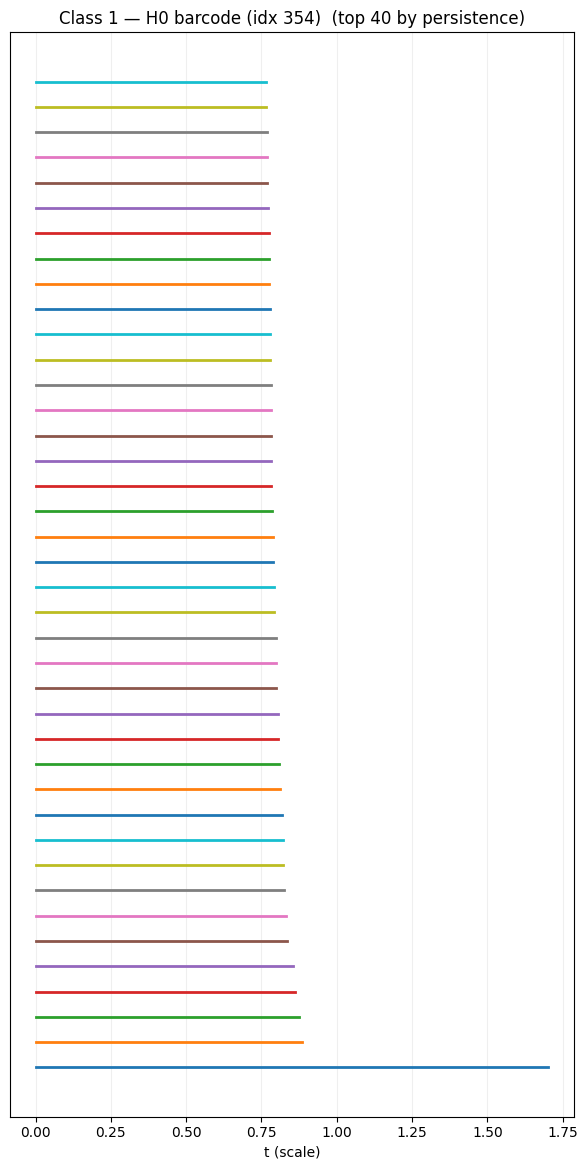

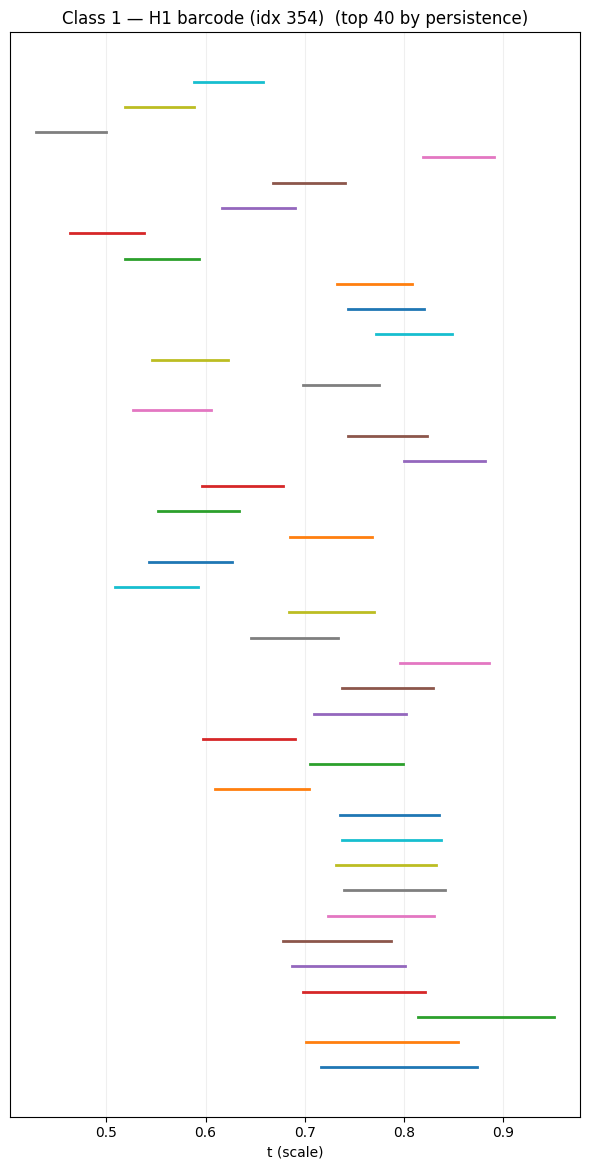

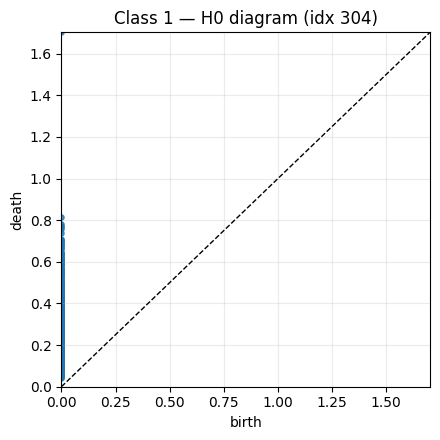

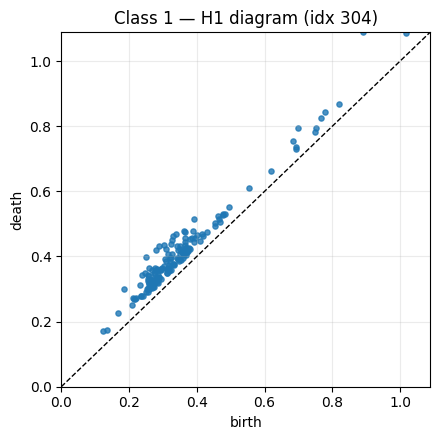

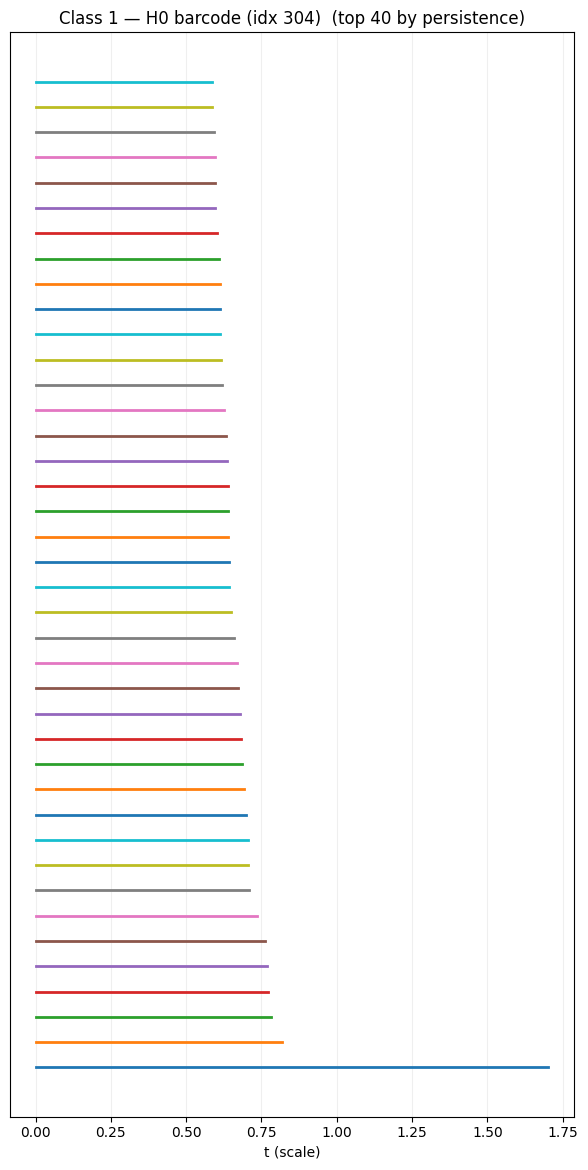

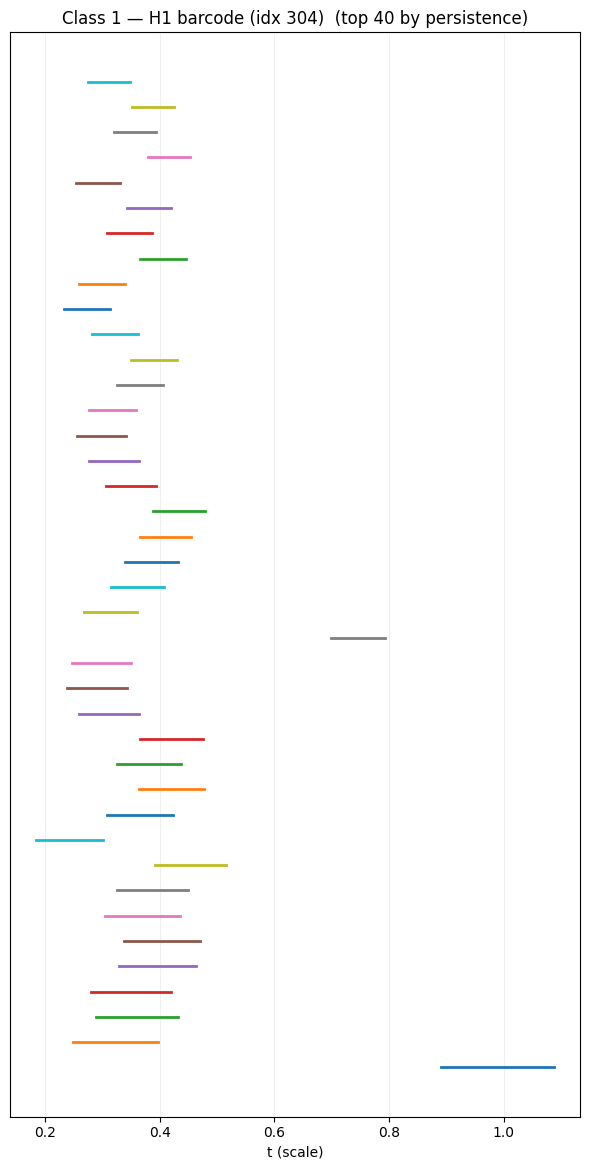

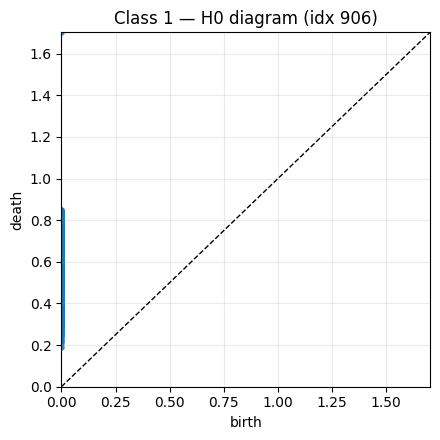

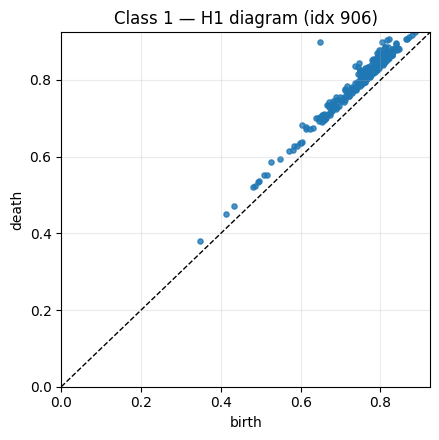

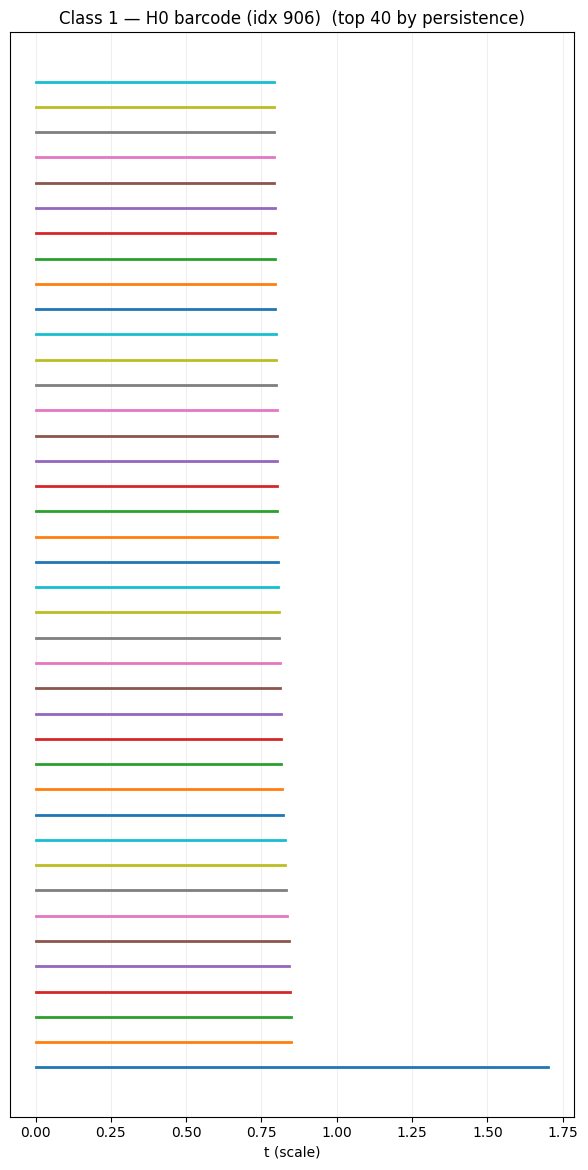

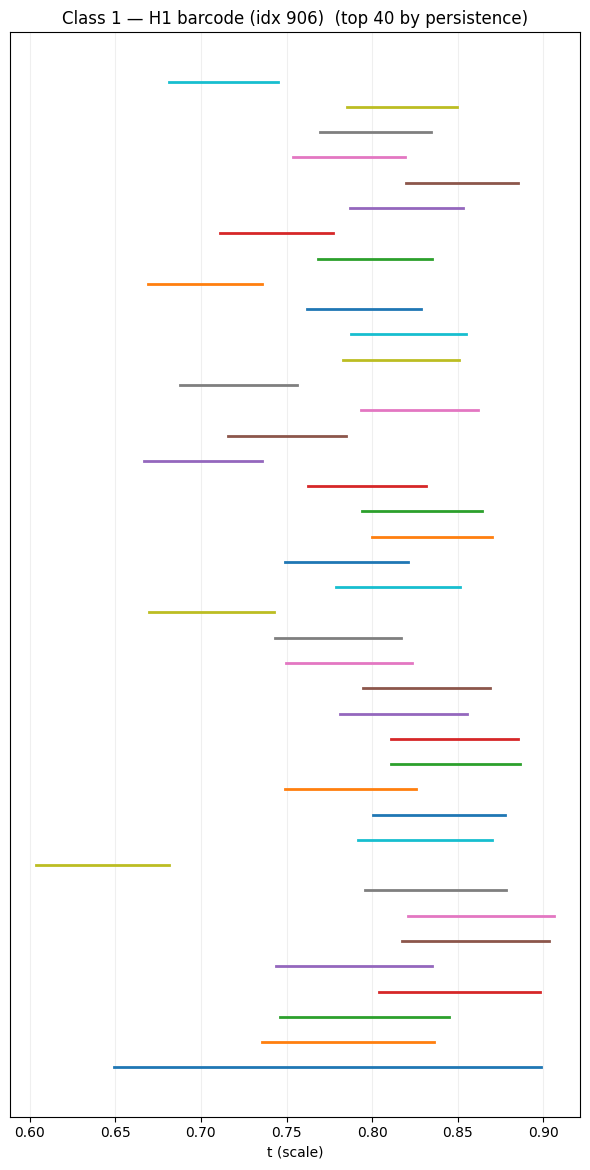

In [31]:
# Assumes Track A variables exist: A_mm, B_mm, idxA, idxB, t_vals, COEFF (or default 2)
t_cap = float(t_vals[-1])
coeff = int(globals().get('COEFF', 2))

rng = np.random.default_rng(0)
N_SHOW = 3  # how many per class

print("Class 0 samples:")
for raw_idx in rng.choice(idxA, size=min(N_SHOW, len(idxA)), replace=False):
    H0, H1 = compute_diagrams_for_clip(A_mm, int(raw_idx), t_cap, coeff=coeff)
    plot_persistence_diagram(H0, f"Class 0 — H0 diagram (idx {int(raw_idx)})")
    plot_persistence_diagram(H1, f"Class 0 — H1 diagram (idx {int(raw_idx)})")
    # Optional barcodes:
    plot_barcode(H0, f"Class 0 — H0 barcode (idx {int(raw_idx)})")
    plot_barcode(H1, f"Class 0 — H1 barcode (idx {int(raw_idx)})")

print("Class 1 samples:")
for raw_idx in rng.choice(idxB, size=min(N_SHOW, len(idxB)), replace=False):
    H0, H1 = compute_diagrams_for_clip(B_mm, int(raw_idx), t_cap, coeff=coeff)
    plot_persistence_diagram(H0, f"Class 1 — H0 diagram (idx {int(raw_idx)})")
    plot_persistence_diagram(H1, f"Class 1 — H1 diagram (idx {int(raw_idx)})")
    plot_barcode(H0, f"Class 1 — H0 barcode (idx {int(raw_idx)})")
    plot_barcode(H1, f"Class 1 — H1 barcode (idx {int(raw_idx)})")


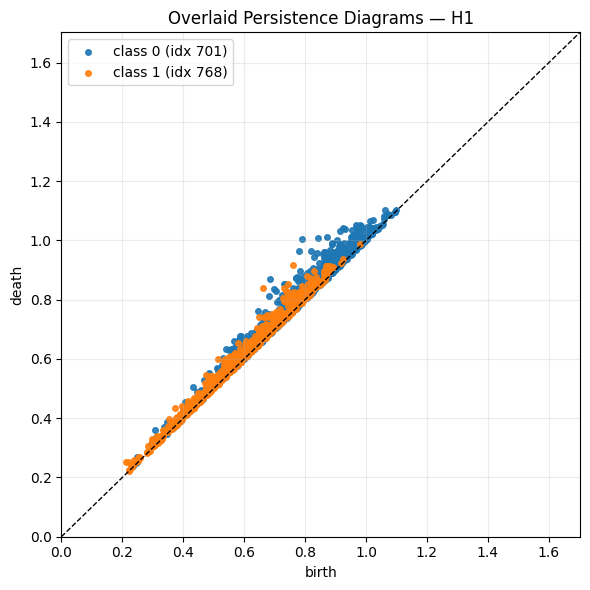

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from ripser import ripser

# Persist the last picks so we avoid repeating them on re-run
if 'LAST_OVERLAY_PICK' not in globals():
    LAST_OVERLAY_PICK = {'i0': None, 'i1': None}

rng   = np.random.default_rng()                 # fresh entropy each run
t_cap = float(t_vals[-1])
coeff = int(globals().get('COEFF', 2))

def _h1_for_clip(mm, raw_idx, t_cap, coeff=2):
    db = np.array(mm[int(raw_idx)], dtype=np.float32)
    pc = spec_to_pointcloud(db)
    if 'USE_PCA' in globals() and USE_PCA and ('PCA_MODEL' in globals()) and (PCA_MODEL is not None):
        pc = PCA_MODEL.transform(pc)
    R = ripser(pc, maxdim=1, thresh=float(t_cap), coeff=int(coeff), do_cocycles=False)
    H1 = R['dgms'][1] if len(R['dgms']) > 1 else np.empty((0,2), float)
    if H1.size:
        finite = np.isfinite(H1[:,1])
        if finite.any():
            m = H1[finite,1].max()
            H1[~finite,1] = m + 1e-6
    return H1

def pick_with_h1(mm, pool, avoid=None, tries=40):
    for _ in range(tries):
        i = int(rng.choice(pool))
        if avoid is not None and i == avoid:
            continue
        H1 = _h1_for_clip(mm, i, t_cap, coeff=coeff)
        if H1.size:
            return i, H1
    # fallback: return a different index even if H1 is empty
    for _ in range(tries):
        i = int(rng.choice(pool))
        if avoid is None or i != avoid:
            return i, _h1_for_clip(mm, i, t_cap, coeff=coeff)
    i = int(rng.choice(pool))
    return i, _h1_for_clip(mm, i, t_cap, coeff=coeff)

idx0, H1_0 = pick_with_h1(A_mm, idxA, avoid=LAST_OVERLAY_PICK['i0'])   # class 0
idx1, H1_1 = pick_with_h1(B_mm, idxB, avoid=LAST_OVERLAY_PICK['i1'])   # class 1
LAST_OVERLAY_PICK['i0'], LAST_OVERLAY_PICK['i1'] = idx0, idx1

plt.figure(figsize=(6,6))
if H1_0.size:
    plt.scatter(H1_0[:,0], H1_0[:,1], s=16, alpha=0.9, label=f"class 0 (idx {idx0})", color="#1f77b4")
if H1_1.size:
    plt.scatter(H1_1[:,0], H1_1[:,1], s=16, alpha=0.9, label=f"class 1 (idx {idx1})", color="#ff7f0e")

lo = 0.0
hi = max([t_cap]
         + ([H1_0[:,0].max(), H1_0[:,1].max()] if H1_0.size else [])
         + ([H1_1[:,0].max(), H1_1[:,1].max()] if H1_1.size else []))
plt.plot([lo, hi], [lo, hi], 'k--', lw=1)
plt.xlim(lo, hi); plt.ylim(lo, hi)
plt.xlabel("birth"); plt.ylabel("death")
plt.title("Overlaid Persistence Diagrams — H1")
plt.grid(True, alpha=0.25)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()
